In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

##### Скачивание данных для работы

In [2]:
df_train = pd.read_csv("train.csv", sep=",", index_col="Id")
df_test = pd.read_csv("test.csv", sep=",", index_col="Id")

##### Обработка пустых значений

In [3]:
medians = df_train[["LifeSquare", "Healthcare_1"]].median()
df_train[["LifeSquare", "Healthcare_1"]] = df_train[["LifeSquare", "Healthcare_1"]].fillna(medians)
df_test[["LifeSquare", "Healthcare_1"]] = df_test[["LifeSquare", "Healthcare_1"]].fillna(medians)

##### Визуализация данных цены

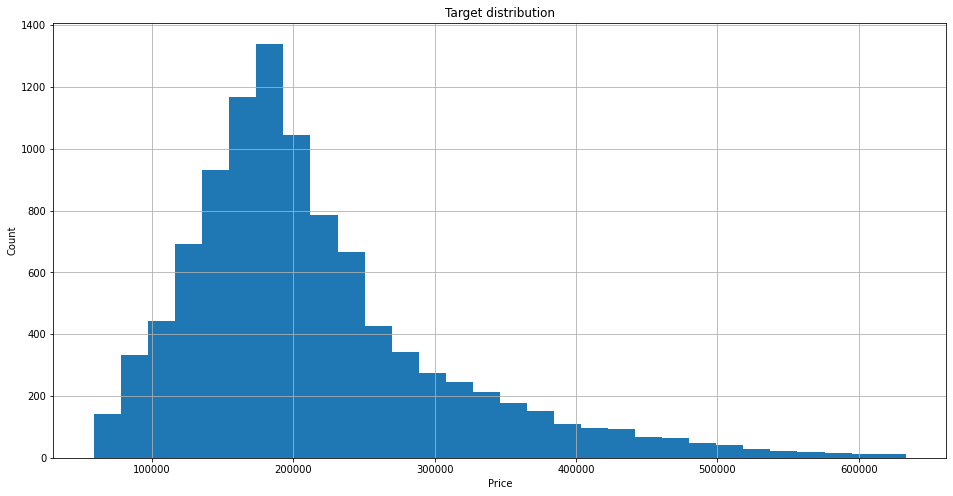

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

##### Построение модели случайного леса

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

model = RandomForestRegressor(n_estimators=1000, max_depth=12,
                              random_state=101)

x_train, x_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != "Price"], df_train["Price"],
                                                    test_size=0.3, random_state=56)

##### Обработка выбросов и бинаризация некоторых выбросов

In [6]:
x_train.loc[(df_train["HouseYear"] > 2021) | (df_train["HouseYear"] < 1500), ["HouseYear"]] = df_train["HouseYear"].median()

x_train.loc[(df_train["Rooms"] > 10000) | (df_train["Rooms"] < 1), ["Rooms"]] = df_train["Rooms"].median()

x_train.loc[df_train["Social_3"] > 10, ["Social_3"]] = df_train["Social_3"].mode().values[0]

x_train.loc[df_train["Ecology_2"] == "A", ["Ecology_2_num"]] = 0
x_train.loc[df_train["Ecology_2"] == "B", ["Ecology_2_num"]] = 1
df_test.loc[df_test["Ecology_2"] == "B", ["Ecology_2_num"]] = 1
df_test.loc[df_test["Ecology_2"] == "A", ["Ecology_2_num"]] = 0
x_test.loc[x_test["Ecology_2"] == "B", ["Ecology_2_num"]] = 1
x_test.loc[x_test["Ecology_2"] == "A", ["Ecology_2_num"]] = 0

x_train.loc[df_train["Ecology_3"] == "A", ["Ecology_3_num"]] = 0
x_train.loc[df_train["Ecology_3"] == "B", ["Ecology_3_num"]] = 1
df_test.loc[df_test["Ecology_3"] == "A", ["Ecology_3_num"]] = 0
df_test.loc[df_test["Ecology_3"] == "B", ["Ecology_3_num"]] = 1
x_test.loc[x_test["Ecology_3"] == "B", ["Ecology_3_num"]] = 1
x_test.loc[x_test["Ecology_3"] == "A", ["Ecology_3_num"]] = 0

x_train.loc[df_train["Shops_2"] == "A", ["Shops_2_num"]] = 0
x_train.loc[df_train["Shops_2"] == "B", ["Shops_2_num"]] = 1
df_test.loc[df_test["Shops_2"] == "A", ["Shops_2_num"]] = 0
df_test.loc[df_test["Shops_2"] == "B", ["Shops_2_num"]] = 1
x_test.loc[x_test["Shops_2"] == "A", ["Shops_2_num"]] = 0
x_test.loc[x_test["Shops_2"] == "B", ["Shops_2_num"]] = 1


x_train.drop(columns=["Ecology_2", "Ecology_3", "Shops_2"], inplace=True)
df_test.drop(columns=["Ecology_2", "Ecology_3", "Shops_2"], inplace=True)
x_test.drop(columns=["Ecology_2", "Ecology_3", "Shops_2"], inplace=True)

##### Обучение модули случайного леса

In [7]:
model.fit(x_train, y_train.to_numpy().flatten())

RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=101)

##### Предсказание модели случайного леса

In [8]:
y_pred = model.predict(x_test)
y_pred

array([182366.68796257, 188853.1498193 , 154789.20415534, ...,
       255166.30980984, 131681.64730654, 196366.09966051])

##### Просчет метрики качества R2

In [9]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.7359287199204243

##### Визуальная проверка

In [10]:
df_eq = pd.DataFrame({'true': y_test, 'pred': y_pred})
df_eq.head()

,true,pred
Id,,
14484,181281.662984,182366.687963
4748,166394.254918,188853.149819
8934,183991.329682,154789.204155
2970,86504.503046,190074.541868
15223,188805.788472,177732.430136


##### Составление модели регрессора бустинга

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls',
          "random_state": 101}

reg = GradientBoostingRegressor(**params)

reg.fit(x_train, y_train)

y_bust_pred = reg.predict(x_test)


##### Оценка каества работы модели регрессора бустинга

In [12]:
r2_score(y_test, y_bust_pred)

0.7139644449542426

##### Предсказание тестового набора данных и выгрузка данных в excel

In [13]:
df_predict = model.predict(df_test)

In [14]:
pd.DataFrame({"Id": df_test.index.values, "Price": df_predict}).to_csv("predict_price.csv", sep=",", index=False)
